<a href="https://colab.research.google.com/github/Kendi7/AI-for-SE-WEEK-7/blob/main/Auditing_dataset_for_biasness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Reinstall from GitHub (more stable for Colab)
!pip install git+https://github.com/Trusted-AI/AIF360.git


  Cloning https://github.com/Trusted-AI/AIF360.git to /tmp/pip-req-build-9c1eb5e1
  Running command git clone --filter=blob:none --quiet https://github.com/Trusted-AI/AIF360.git /tmp/pip-req-build-9c1eb5e1
  Resolved https://github.com/Trusted-AI/AIF360.git to commit cd7e2138b7919e0796db7e7902bf49b20065f4f8
  Preparing metadata (setup.py) ... done


In [1]:
# Install dependencies
!pip install -q aif360 pandas matplotlib seaborn scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [6]:
!pip install -q git+https://github.com/Trusted-AI/AIF360.git


  Preparing metadata (setup.py) ... done


In [7]:
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv


--2025-07-24 13:18:02--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.08s   

2025-07-24 13:18:03 (31.8 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]



In [9]:
# Drop only existing columns
columns_to_drop = [
    'name', 'first', 'last', 'compas_screening_date', 'dob', 'age',
    'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date',
    'c_arrest_date', 'c_days_from_compas', 'c_charge_desc',
    'decile_score', 'v_score_text', 'v_decile_score',
    'screening_date', 'in_custody', 'out_custody'
]

# Drop only the columns that actually exist
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


In [10]:
df = df.rename(columns={'two_year_recid': 'label'})
df['label'] = df['label'].astype(int)


In [11]:
from aif360.datasets import StandardDataset

dataset = StandardDataset(
    df,
    label_name='label',
    favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[[1]],
    features_to_drop=[]  # already dropped manually
)


In [12]:
# Remove rows with missing values (essential for StandardDataset)
df = df.dropna()


In [13]:
privileged_classes=[[1]]  # expecting '1' = Caucasian


In [14]:
# Map


In [15]:
privileged_groups = [{'race': 1}]       # Caucasian
unprivileged_groups = [{'race': 0}]     # African-American


In [16]:
from aif360.metrics import BinaryLabelDatasetMetric

metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

print("Disparate Impact:", round(metric.disparate_impact(), 3))
print("Mean Difference:", round(metric.mean_difference(), 3))


Disparate Impact: nan
Mean Difference: nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)


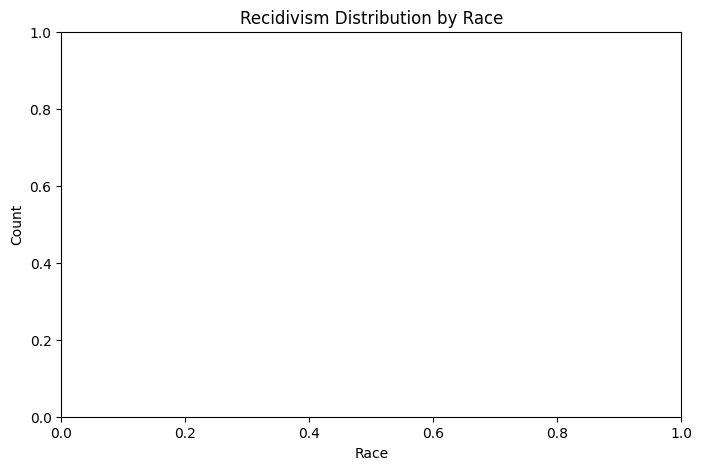

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert dataset back to DataFrame for plotting
df_plot, _ = dataset.convert_to_dataframe()

# Map race for readability
df_plot['race'] = df_plot['race'].map({0: 'African-American', 1: 'Caucasian'})
df_plot['label'] = df_plot['label'].map({0: 'No Recidivism', 1: 'Recidivism'})

# Plot
plt.figure(figsize=(8,5))
sns.countplot(data=df_plot, x='race', hue='label', palette='Set2')
plt.title("Recidivism Distribution by Race")
plt.ylabel("Count")
plt.xlabel("Race")
plt.show()


In [19]:
from aif360.algorithms.preprocessing import Reweighing

# Apply reweighing
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = rw.fit_transform(dataset)

# Check metrics again
metric_rw = BinaryLabelDatasetMetric(
    dataset_transf,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

print("Post-Reweighing Disparate Impact:", round(metric_rw.disparate_impact(), 3))
print("Post-Reweighing Mean Difference:", round(metric_rw.mean_difference(), 3))


Post-Reweighing Disparate Impact: nan
Post-Reweighing Mean Difference: nan


/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:66: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:67: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:69: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_unfav = n_unfav*n_up / (n*n_up_unfav)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)


Second **Trial** **bold text**

In [20]:
# Check race distribution
print(df['race'].value_counts())

# Check label distribution
print(df['label'].value_counts())

# Cross-tabulate to see combinations
pd.crosstab(df['race'], df['label'], rownames=['Race'], colnames=['Recidivism Label'])


Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


Recidivism Label
Race


In [21]:
df = df[df['label'].isin([0,1]) & df['race'].isin([0,1])]


In [22]:
from aif360.datasets import StandardDataset

dataset = StandardDataset(
    df,
    label_name='label',
    favorable_classes=[0],     # 0 = No recidivism
    protected_attribute_names=['race'],
    privileged_classes=[[1]],  # 1 = Caucasian
    features_to_drop=['sex']   # optional
)


In [23]:
from aif360.metrics import BinaryLabelDatasetMetric

metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{'race': 1}],
    unprivileged_groups=[{'race': 0}]
)

print("Disparate Impact:", round(metric.disparate_impact(), 3))
print("Mean Difference:", round(metric.mean_difference(), 3))


Disparate Impact: nan
Mean Difference: nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)


In [ ]:
dataset.convert_to_dataframe()[0]['race'].value_counts()
dataset.convert_to_dataframe()[0]['label'].value_counts()

